# Cam-Follower Synthesis Analysis

This notebook performs a comprehensive kinematic analysis and design optimization of a flat-face cam-follower mechanism. The analysis includes:

- **Defining the cam profile** using polynomial and cycloidal motion equations
- **Computing kinematic properties**: displacement $y(\theta)$, velocity $\dot{y}$, and acceleration $\ddot{y}$
- **Finding critical design parameters**: base radius, eccentricity, pressure angle
- **Optimizing performance**: locating maximum/minimum values for velocity, acceleration, and radius of curvature

---

## Import Libraries
Essential Python libraries for symbolic mathematics, numerical computation, optimization, and visualization.

In [13]:
import numpy as np
import sympy as sp
import scipy
import matplotlib.pyplot as plt

## Major Formulae for flat face Cam follower
1. $r_b \ge \rho_\text{min} - \left[y\left(\theta\right) + {y}"\left(\theta\right) \right]_\text{min},\, \theta \in \left[0, \theta_{r_i}\right]$
2. $e \ge \left[y'\left(\theta\right)\right]_\text{max} - \epsilon_\text{max}, \, \theta \in \left[0, \theta_{r_i}\right]$
3. $w_\text{follower, min} = y'(\theta)_\text{max} + \left|y'(\theta)_\text{min}\right|$

# Writing the function for cam profile
This part of the code defines the cam profile $y(\theta)$.
Using `sympy`, it is defined symbolically, allowing for easy differentiation and manipulation.
## Example code
$y(\theta)$ in my case looks something like this: 

$$
y(\theta) =
\begin{cases}
L_1 \left[ 6\left( \frac{\theta}{\theta_{R_1}} \right)^5 
- 15\left( \frac{\theta}{\theta_{R_1}} \right)^4 
+ 10\left( \frac{\theta}{\theta_{R_1}} \right)^3 \right], 
& 0 \leq \theta \leq \theta_{R_1} \\[10pt]
L_1, 
& \theta_{R_1} < \theta \leq (\theta_{R_1} + \theta_{D}) \\[10pt]
L_1 + L_2 \left[ 
\frac{\theta - (\theta_{R_1} + \theta_{D})}{\theta_{RI2}} 
- \frac{\sin\!\left( 2\pi \frac{\theta - (\theta_{R_1} + \theta_{D})}{\theta_{RI2}} \right)}{2\pi}
\right], 
& (\theta_{R_1} + \theta_{D}) < \theta \leq (\theta_{R_1} + \theta_{D} + \theta_{R_2})
\end{cases}
$$

And $\omega = 3$ rpm.

In [14]:
THETA_RI1 = 110*np.pi/180
THETA_RI2 = 60*np.pi/180
THETA_D = 10*np.pi/180
L1 = 40
L2 = 20
OMEGA = 3*2*np.pi/60  # rad/s

In [15]:
t = sp.symbols("t")
theta = sp.Function("theta")(t)
y_r1 = sp.Function("y")(theta)
y_f = sp.Function("y")(theta)

y_r1 = L1* ( 6*(theta/THETA_RI1)**5 -15*(theta/THETA_RI1)**4 +10*(theta/THETA_RI1)**3)
y_r2 = L1 + L2*(((theta-(THETA_RI1+THETA_D))/THETA_RI2)-sp.sin(2*np.pi*(theta-(THETA_RI1+THETA_D))/THETA_RI2)/(2*np.pi))
# y rising 1
# y rising 2
y_u = sp.Piecewise(
    (y_r1, (theta >= 0) & (theta <= THETA_RI1)),
    (L1, (theta > THETA_RI1) & (theta <= (THETA_RI1 + THETA_D))),
    (y_r2, (theta > (THETA_RI1 + THETA_D)) & (theta <= (THETA_RI1 + THETA_D + THETA_RI2)))
)
# y upwards = y in the entire code

Visualising the profile by seeing the piecewise definition, and plotting it over the full range of $\theta$.

In [16]:
y_u

Piecewise((9.20154973737825*theta(t)**5 - 44.1642682808993*theta(t)**4 + 56.5262055039578*theta(t)**3, (theta(t) <= 1.91986217719376) & (theta(t) >= 0)), (40, (theta(t) <= 2.0943951023932) & (theta(t) > 1.91986217719376)), (19.0985931710274*theta(t) - 3.18309886183791*sin(6.0*theta(t) - 12.5663706143592), (theta(t) <= 3.14159265358979) & (theta(t) > 2.0943951023932)))

max theta: 3.142, min theta: 0.0
max yu: 59.996, min yu: 0.0


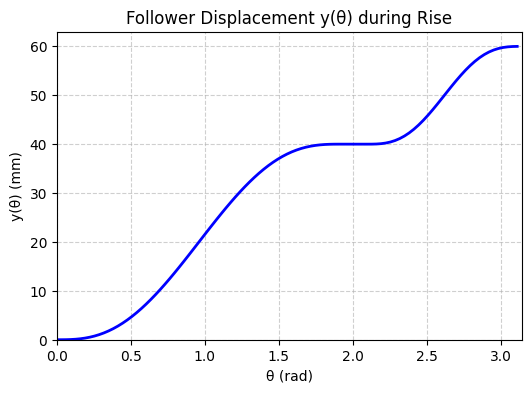

In [48]:
theta_vals = np.linspace(0, np.pi, 100)
y_lambda = sp.lambdify(
    expr=y_u,
    args=theta,
    modules='numpy') # This is defined later again. 
y_vals = y_lambda(theta_vals)

plt.figure(figsize=(6,4))
plt.plot(theta_vals, y_vals, color='blue', linewidth=2)
plt.title('Follower Displacement y(θ) during Rise')
plt.xlabel('θ (rad)')
plt.ylabel('y(θ) (mm)')
plt.xlim(theta_vals.min(), theta_vals.max())
plt.ylim(min(y_vals)*1.05 if min(y_vals) < 0 else 0, max(y_vals)*1.05)
plt.grid(True, linestyle='--', alpha=0.6)

print(f"max theta: {max(theta_vals):.3f}, min theta: {min(theta_vals)}")
print(f"max yu: {max(y_vals):.3f}, min yu: {min(y_vals)}")

---

# Part 1: Kinematic Analysis - Derivatives and Plotting

## Calculate First and Second Derivatives

Compute the derivatives of $y_u(\theta)$ with respect to $\theta$:
- **dashy** = $\frac{dy}{d\theta}$ (first derivative - related to velocity)
- **ddashy** = $\frac{d^2y}{d\theta^2}$ (second derivative - related to acceleration)

Convert symbolic expressions to numerical functions using `lambdify` for efficient plotting and optimization. These are used later as helper functions.

In [18]:
dashy = sp.diff(y_u, theta)
ddashy = sp.diff(dashy, theta)

y_lambda = sp.lambdify(
    expr=y_u,
    args=theta,
    modules='numpy')

dashy_lambda = sp.lambdify(
    expr=dashy,
    args=theta,
    modules='numpy')

ddashy_lambda = sp.lambdify(
    expr=ddashy,
    args=theta,
    modules='numpy')

## Calculate and Plot Velocity $\dot{y}(t)$

Compute the follower velocity by applying the chain rule:
$$\dot{y} = \frac{dy}{dt} = \frac{dy}{d\theta} \cdot \frac{d\theta}{dt} = \frac{dy}{d\theta} \cdot \omega$$

Plot the velocity profile to identify where maximum velocity occurs.\
Using `sympy` here proves useful, as it allows symbolic differentiation and easy conversion to numerical functions for plotting.

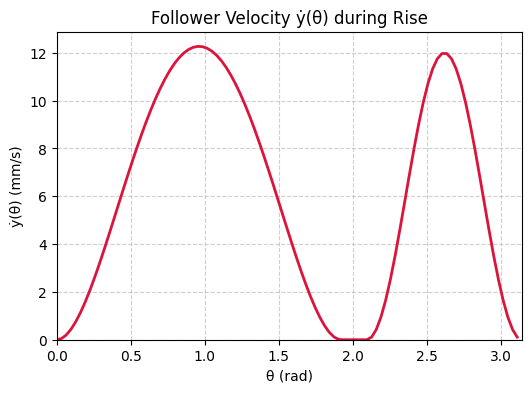

In [49]:
doty = sp.diff(y_u, t).subs({sp.diff(theta, t): OMEGA}).evalf()
doty_lambda = sp.lambdify(expr=doty, args=theta, modules='numpy')

doty_vals = doty_lambda(theta_vals)

plt.figure(figsize=(6,4))
plt.plot(theta_vals, doty_vals, color='crimson', linewidth=2)
plt.title('Follower Velocity ẏ(θ) during Rise')
plt.xlabel('θ (rad)')
plt.ylabel('ẏ(θ) (mm/s)')
plt.xlim(theta_vals.min(), theta_vals.max())
plt.ylim(min(doty_vals)*1.05 if min(doty_vals) < 0 else 0, max(doty_vals)*1.05)
plt.grid(True, linestyle='--', alpha=0.6)

### Find Maximum Velocity
Use scipy optimization to find the **maximum follower velocity** during upward motion and the angle at which it occurs.

**Finding:** Maximum velocity and corresponding theta angle.\
Use the graph for a rough estimate of $x_0$ for scipy optimization.

In [65]:
doty_max_res = scipy.optimize.minimize(
    sp.lambdify(expr=-doty, args=theta, modules='numpy'),
    x0=1.0,
    bounds=[(0, THETA_RI1 + THETA_D + THETA_RI2)]
)

# extract single scalar element to avoid DeprecationWarning
doty_max_theta = float(doty_max_res.x[0])
doty_max_val = -doty_max_res.fun

print(
    f"Max upward velocity = {doty_max_val:.4f} mm/s at θ = {doty_max_theta:.4f} rad")
# doty_max_res

Max upward velocity = 12.2727 mm/s at θ = 0.9599 rad


### Plot Second Derivative
Visualize $\frac{d^2y}{d\theta^2}$

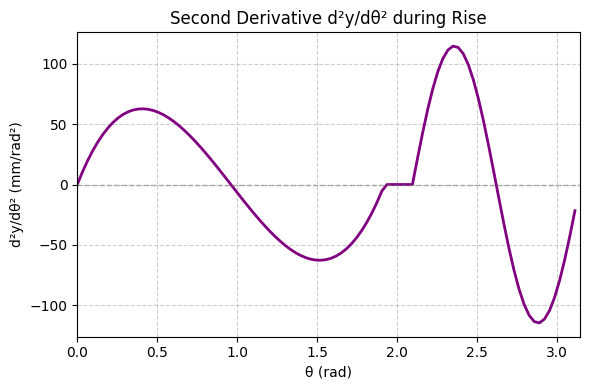

In [66]:
plt.figure(figsize=(6,4))
vals_ddashy = ddashy_lambda(theta_vals)

plt.plot(theta_vals, vals_ddashy, color='purple', linewidth=2)
plt.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.6)

plt.title('Second Derivative d²y/dθ² during Rise')
plt.xlabel('θ (rad)')
plt.ylabel('d²y/dθ² (mm/rad²)')
plt.xlim(theta_vals.min(), theta_vals.max())
plt.ylim(min(vals_ddashy)*1.1, max(vals_ddashy)*1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

---

## Define and Analyze Downward (Return) Motion

### Create Downward Motion Profile $y_d(\theta)$
Define the return motion using a **cycloidal profile** that brings the follower from maximum height (L1 + L2) back to zero.

The angle range for return is: $\theta_{RE} = 2\pi - (\theta_{RI1} + \theta_D + \theta_{RI2})$

In [67]:
y_d = sp.Function("y_d")(theta)
# Defining the downward motion
THETA_RE = 2*np.pi - (THETA_RI1 + THETA_D + THETA_RI2)
y_d = (L1 + L2)*(((2*np.pi-theta)/THETA_RE)-sp.sin(2*np.pi*(2*np.pi-theta)/THETA_RE)/(2*np.pi))

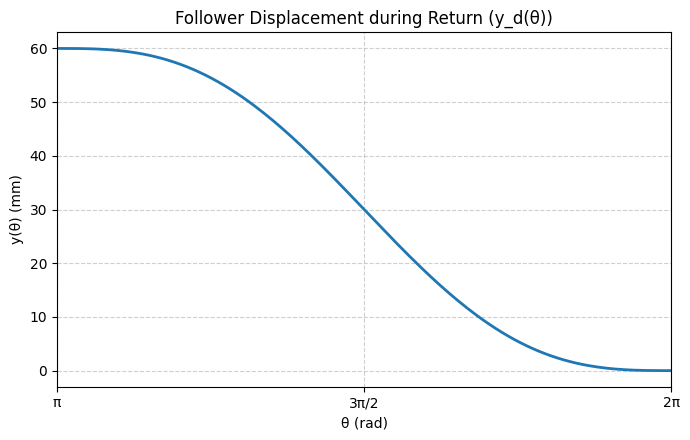

In [68]:
yd_lambda = sp.lambdify(expr=y_d, args=theta, modules='numpy')
theta_vals3 = np.linspace(np.pi, 2*np.pi, 200)
y_vals3 = yd_lambda(theta_vals3)

plt.figure(figsize=(7,4.5))
plt.plot(theta_vals3, y_vals3, color='tab:blue', linewidth=2, linestyle='-')
plt.title('Follower Displacement during Return (y_d(θ))')
plt.xlabel('θ (rad)')
plt.ylabel('y(θ) (mm)')
plt.xlim(theta_vals3.min(), theta_vals3.max())
ymin, ymax = y_vals3.min(), y_vals3.max()
ymargin = 0.05*(ymax - ymin) if ymax != ymin else 1.0
plt.ylim(ymin - ymargin, ymax + ymargin)
plt.xticks([np.pi, 1.5*np.pi, 2*np.pi], ['π', '3π/2', '2π'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

### Combine into Complete Cam Profile $y_{rf}(\theta)$
Create the **full cam profile** covering the entire rotation (0 to 2π) by combining:
- Upward motion: $y_u(\theta)$
- Downward motion: $y_d(\theta)$

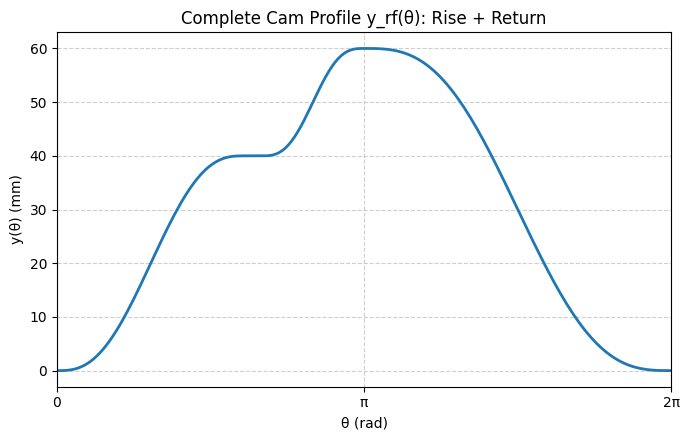

In [69]:
y_rf = sp.Piecewise(
    (y_u, theta <= (THETA_RI1 + THETA_D + THETA_RI2)),
    (y_d, theta > (THETA_RI1 + THETA_D + THETA_RI2))
)
yrf_lambda = sp.lambdify(expr=y_rf, args=theta, modules='numpy')

theta_vals2 = np.linspace(0, 2*np.pi, 200)
y_vals2 = yrf_lambda(theta_vals2)

plt.figure(figsize=(7,4.5))
plt.plot(theta_vals2, y_vals2, color='tab:blue', linewidth=2)
plt.title('Complete Cam Profile y_rf(θ): Rise + Return')
plt.xlabel('θ (rad)')
plt.ylabel('y(θ) (mm)')
plt.xlim(theta_vals2.min(), theta_vals2.max())
ymin, ymax = y_vals2.min(), y_vals2.max()
ymargin = 0.05*(ymax - ymin) if ymax != ymin else 1.0
plt.ylim(ymin - ymargin, ymax + ymargin)
plt.xticks([0, np.pi, 2*np.pi], ['0', 'π', '2π'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
# Total y function denoted by yrf y rise fall

### Calculate and Plot Return Velocity
Compute the velocity during the **downward (return) phase** to analyze the return motion characteristics.

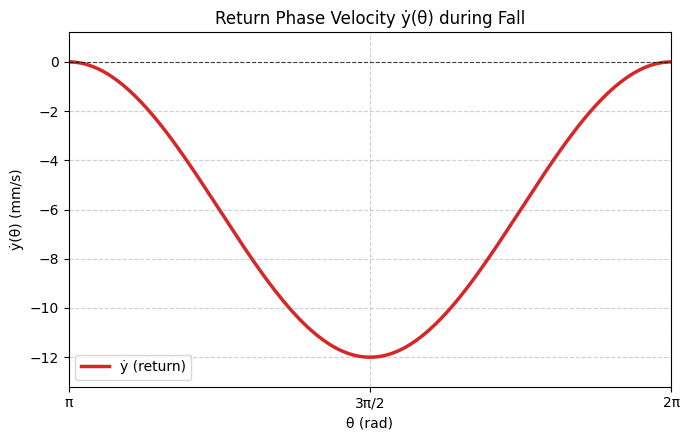

In [70]:
doty_yd = sp.diff(y_d, t).subs({sp.diff(theta, t): OMEGA}).evalf()
doty_yd_lambda = sp.lambdify(
    expr = doty_yd,
    args = theta,
    modules = 'numpy')

dotyd_vals = doty_yd_lambda(theta_vals3)

plt.figure(figsize=(7,4.5))
plt.plot(theta_vals3, dotyd_vals, color='tab:red', linewidth=2.5, label='ẏ (return)')
plt.title('Return Phase Velocity ẏ(θ) during Fall')
plt.xlabel('θ (rad)')
plt.ylabel('ẏ(θ) (mm/s)')
plt.axhline(0, color='k', linewidth=0.8, linestyle='--', alpha=0.7)
plt.xlim(theta_vals3.min(), theta_vals3.max())
ymin, ymax = dotyd_vals.min(), dotyd_vals.max()
ymargin = 0.1*(ymax - ymin) if ymax != ymin else 1.0
plt.ylim(ymin - ymargin, ymax + ymargin)
plt.xticks([np.pi, 1.5*np.pi, 2*np.pi], ['π', '3π/2', '2π'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

### Find Maximum Downward Velocity
Optimize to find the **maximum downward (return) velocity**.

**Finding:** Maximum return velocity during the fall phase.\
Use $x_0$ from the graph for a rough estimate for scipy optimization.

In [71]:
dotyd_min = scipy.optimize.minimize(
    sp.lambdify(expr=doty_yd, args=theta, modules='numpy'),
    x0=4.8,
    bounds=[(THETA_RI1 + THETA_D + THETA_RI2, 2*np.pi)]
)

# Extract and display results
dotyd_min_theta = float(dotyd_min.x[0])
dotyd_min_val = dotyd_min.fun
print(f"Max downward velocity ≈ {-dotyd_min_val:.4f} mm/s at θ = {dotyd_min_theta:.4f} rad")

Max downward velocity ≈ 12.0000 mm/s at θ = 4.7124 rad


---

## Part 2: Design Parameter Calculations
### Part 2a: Flat Face Follower Assumptions
#### Calculate Minimum Radius of Curvature (Part g)

The radius of curvature constraint for a flat-face follower is:
$$\rho = r_b + y(\theta) + y''(\theta)$$

To avoid undercutting, we need $\rho > 0$ everywhere. This cell finds the **minimum value** of $y(\theta) + y''(\theta)$ to determine the required base radius.
Given a base radius $r_b = 150$ mm, find the minimum radius of curvature during the rise phase.

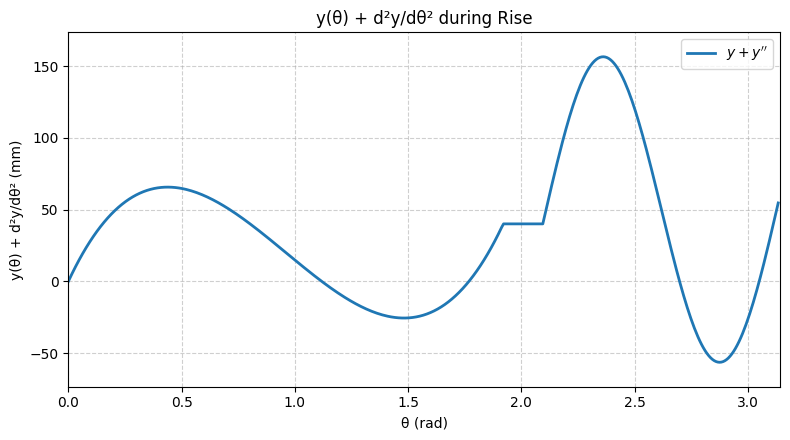

In [81]:
theta_rise = np.linspace(0, THETA_RI1 + THETA_D + THETA_RI2, 400)
f_lambda = sp.lambdify(expr=y_u + ddashy, args=theta, modules='numpy')
f_vals = np.asarray(f_lambda(theta_rise), dtype=float)

# compute minimum only if not already defined
if 'yddashy_min' not in globals():
    yddashy_min = scipy.optimize.minimize(
        lambda th: float(np.asarray(f_lambda(th)).squeeze()),
        x0=3,
        bounds=[(0, THETA_RI1 + THETA_D + THETA_RI2)]
    )

theta_min = float(yddashy_min.x[0])
f_min = float(yddashy_min.fun)

# handle non-finite values for plotting/limits
finite_mask = np.isfinite(f_vals)
f_plot = np.where(finite_mask, f_vals, np.nan)

plt.figure(figsize=(8, 4.5))
plt.plot(theta_rise, f_plot, color='tab:blue', linewidth=2, label=r'$y + y^{\prime\prime}$')

plt.title('y(θ) + d²y/dθ² during Rise')
plt.xlabel('θ (rad)')
plt.ylabel('y(θ) + d²y/dθ² (mm)')
plt.xlim(0, THETA_RI1 + THETA_D + THETA_RI2)

if finite_mask.any():
    ymin, ymax = f_vals[finite_mask].min(), f_vals[finite_mask].max()
    ymargin = 0.08 * (ymax - ymin) if ymax != ymin else 1.0
    plt.ylim(ymin - ymargin, ymax + ymargin)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

### Find Minimum Value of $y + y''$
Optimize to locate where $y(\theta) + y''(\theta)$ reaches its minimum during upward motion.
**Finding:** Minimum contribution to radius of curvature during rise phase.\
Use the graph for a rough estimate of $x_0$ for scipy optimization.

In [78]:
yddashy_min = scipy.optimize.minimize(
    sp.lambdify(expr=y_u + ddashy,
                args=theta,
                modules='numpy'),
    x0=3,
    bounds=[(0, THETA_RI1+THETA_D+THETA_RI2)])
yddashy_min_theta = float(yddashy_min.x[0])
yddashy_min_val = yddashy_min.fun
print(
    f"Min y+y\" = {-dotyd_min_val:.4f} mm at θ = {dotyd_min_theta:.4f} rad")

Min y+y" = 12.0000 mm at θ = 4.7124 rad


In [80]:
rb = 150
min_roc = rb+yddashy_min.fun # minimum radius of curvature

print(f"Minimum Radius of Curvature during Rise: {min_roc:.3f} mm")

Minimum Radius of Curvature during Rise: 93.546 mm


### Calculate Minimum Eccentricity (Part h)

For cam-follower design, the eccentricity constraint is:
$$e \ge y'(\theta)_{\text{max}} - \epsilon_{\text{max}}$$

Where $\epsilon_{\text{max}}$ is the maximum allowable pressure angle factor. This section:
1. Plots $y'(\theta)$ during rise
2. Finds maximum value of $y'(\theta)$
3. Calculates minimum required eccentricity given max allowable eccentricity of 30 mm

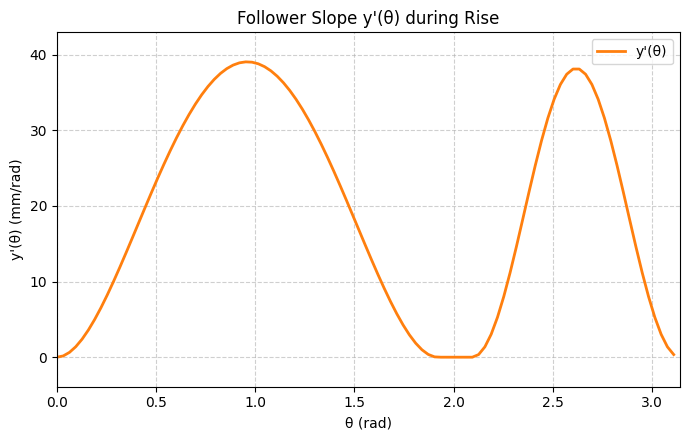

In [85]:
plt.figure(figsize=(7,4.5))
vals = dashy_lambda(theta_vals)
plt.plot(theta_vals, vals, color='tab:orange', linewidth=2, label="y'(θ)")
plt.title("Follower Slope y'(θ) during Rise")
plt.xlabel('θ (rad)')
plt.ylabel("y'(θ) (mm/rad)")
plt.xlim(theta_vals.min(), theta_vals.max())
ymin, ymax = np.nanmin(vals), np.nanmax(vals)
ymargin = 0.1*(ymax - ymin) if ymax != ymin else 1.0
plt.ylim(ymin - ymargin, ymax + ymargin)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
# theta_vals implies while rising

In [88]:
dashy_max = scipy.optimize.minimize(
    sp.lambdify(expr=-dashy, args=theta, modules='numpy'),
    x0=1.0,
    bounds=[(0, THETA_RI1 + THETA_D + THETA_RI2)]
)

dashy_max_theta = float(dashy_max.x[0])
dashy_max_val = -float(dashy_max.fun)

print(f"Max y' = {dashy_max_val:.4f} mm/rad at θ = {dashy_max_theta:.4f} rad")

Max y' = 39.0653 mm/rad at θ = 0.9599 rad


In [90]:
Max_eccen = 30
e_min = dashy_max_val - Max_eccen
print(
    f"Minimum eccentricity required for the flat face follower is: {e_min:.3f} mm")

Minimum eccentricity required for the flat face follower is: 9.065 mm


---

### Part 2b: Roller Face Follower Assumptions

### Define Pressure Angle Formula

The **pressure angle** $\alpha$ for a flat-face follower is given by:
$$\alpha = \tan^{-1}\left(\frac{y'(\theta) - e}{y(\theta) + \sqrt{r_p^2 - e^2}}\right)$$

Where:
- $e$ = eccentricity (set to 0 for this analysis)
- $r_p$ = prime circle radius = 170 mm
- $y'(\theta)$ = first derivative of displacement
- $y(\theta)$ = follower displacement

In [ ]:
# For our example case, 
e = 0
r_p = 170
pres_ang = sp.atan((dashy-e)/(y_u+sp.sqrt(r_p**2 - e**2)))

### Plot Pressure Angle Profile
Visualize how the pressure angle varies during the rise phase to identify critical regions.

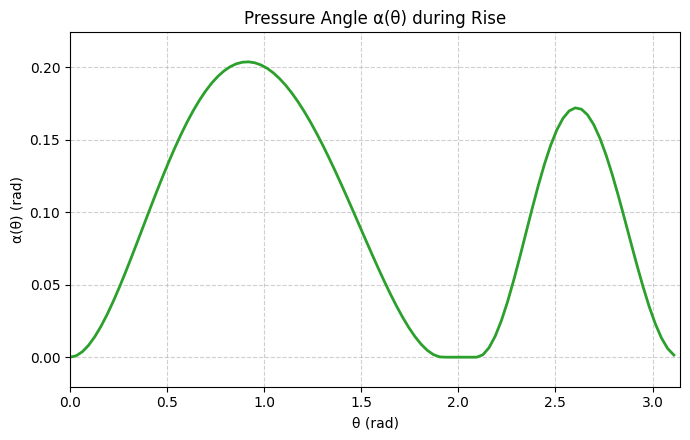

In [91]:
pres_ang_lambda = sp.lambdify(
    expr = pres_ang,
    args = theta,
    modules = 'numpy') 
plt.figure(figsize=(7,4.5))
vals = pres_ang_lambda(theta_vals)
plt.plot(theta_vals, vals, color='tab:green', linewidth=2)
plt.title('Pressure Angle α(θ) during Rise')
plt.xlabel('θ (rad)')
plt.ylabel('α(θ) (rad)')
plt.xlim(theta_vals.min(), theta_vals.max())
ymin, ymax = np.nanmin(vals), np.nanmax(vals)
ymargin = 0.1 * (ymax - ymin) if ymax != ymin else 0.1
plt.ylim(ymin - ymargin, ymax + ymargin)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

### Find Maximum Pressure Angle
Optimize to determine the **maximum pressure angle** and where it occurs.

**Finding:** Maximum pressure angle magnitude and corresponding theta (important for checking if it exceeds design limits, typically 30°).\
Use the graph for a rough estimate of $x_0$ for scipy optimization.

In [93]:
max_pres_angle = scipy.optimize.minimize(
    sp.lambdify(
    expr = -pres_ang,
    args = theta,
    modules = 'numpy'),
    x0 = 1,
    bounds = [(0, THETA_RI1 + THETA_D + THETA_RI2)])
pres_angle_theta = float(max_pres_angle.x[0])
pres_angle_val = -float(max_pres_angle.fun)
print(f"Max Pressure Angle = {pres_angle_val:.4f} rad at θ = {pres_angle_theta:.4f} rad")

Max Pressure Angle = 0.2037 rad at θ = 0.9125 rad


### Calculate Maximum Trace Point Distance

The **trace point** is the contact point on the cam surface. Its distance from the cam center is:
$$R = \sqrt{X^2 + Y^2}$$

Where:
- $Y = y(\theta) + \sqrt{r_p^2 - e^2}$ (vertical component)
- $X = e$ (horizontal component, = 0 in this case)

This section finds the maximum radial distance, which determines the **cam size**.

In [40]:
Y = y_u + sp.sqrt(r_p**2 - e**2)
X = e # X = 0
R = sp.sqrt(Y**2 + X**2)

### Plot Y-Component of Trace Point
Visualize the Y-coordinate of the trace point as a function of theta to understand how the cam radius varies, since R in this case is equal to Y.

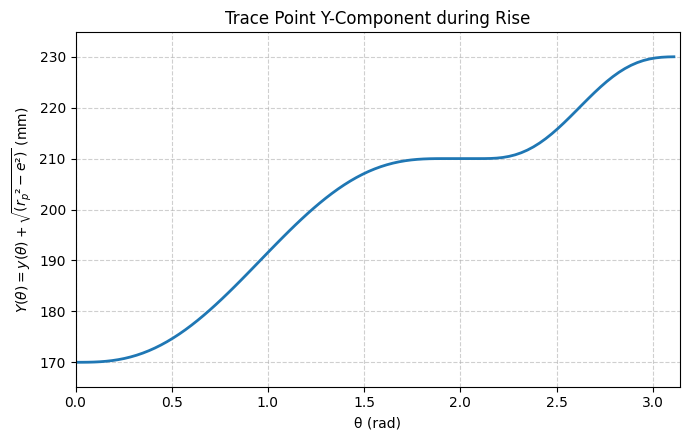

In [95]:
y_comp = sp.lambdify(expr=Y, args=theta, modules='numpy')(theta_vals)

plt.figure(figsize=(7, 4.5))
plt.plot(theta_vals, y_comp, color='tab:blue', linewidth=2)
plt.title('Trace Point Y-Component during Rise')
plt.xlabel('θ (rad)')
plt.ylabel('$Y(θ) = y(θ) + \sqrt{(r_p² - e²)}$ (mm)')
plt.xlim(theta_vals.min(), theta_vals.max())
ymin, ymax = np.nanmin(y_comp), np.nanmax(y_comp)
ymargin = 0.08 * (ymax - ymin) if ymax != ymin else 1.0
plt.ylim(ymin - ymargin, ymax + ymargin)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

### Find Maximum Radial Distance
Optimize to find the **maximum trace point distance** from the cam center during the rise phase.

**Finding:** Maximum cam radius required (important for determining overall cam size).

Use the graph for a rough estimate of $x_0$ for scipy optimization.

In [97]:
R_max = scipy.optimize.minimize(
    sp.lambdify(
    expr=-R,
    args=theta,
    modules='numpy'),
    x0 = 3.14,
    bounds = [(0, THETA_RI1 + THETA_D + THETA_RI2)])
R_max_theta = float(R_max.x[0])
R_max_val = -float(R_max.fun)
print(f"Max Trace Point Radius R = {R_max_val:.4f} mm at θ = {R_max_theta:.4f} rad")

Max Trace Point Radius R = 230.0000 mm at θ = 3.1409 rad
